<a href="https://colab.research.google.com/github/FelipeFerAl/TAM-2025-2/blob/main/ClassExercises/TAM180925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

M = 1000  #Número de simulaciones de MonteCarlo
N = 100
A = 5

A1 = np.zeros((M,1))
A2 = np.zeros((M,1))
for m in range(M):
  # print(f"Simulación {m+1}/{M} de Monte Carlo...")
  w = np.random.randn(N)  #Ruido
  x = A + w
  A1[m] = np.mean(x) #Estimador 1 -> Promedio i.i.d. verosimilitud gaussiana
  A2[m] = x[0] #Estimador 2 -> Promedio igual a la muestra 1

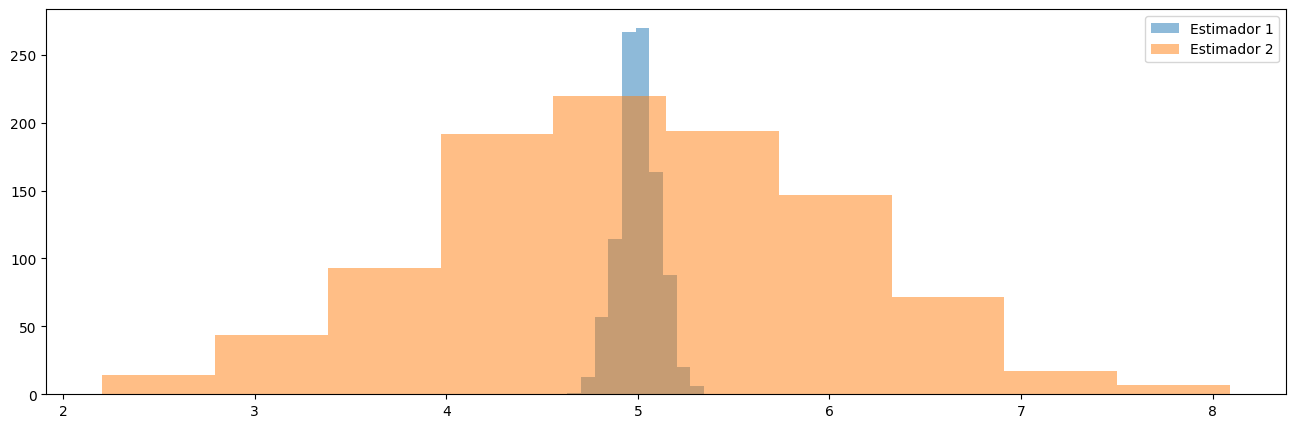

In [2]:
plt.figure(figsize=(16,5))
plt.hist(A1, label='Estimador 1', alpha=0.5)
plt.hist(A2, label='Estimador 2', alpha=0.5)
plt.legend()
plt.show()

#EJERCICIO

In [3]:
#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

In [4]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(0,To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 10 #ruido según SNR dB
#señal limpia - objetivo
tt = A*np.sin(2*np.pi*Fo*X)
#modelo con función sinoidal contaminada con ruido Gaussiano
t = A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X))

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)

In [24]:
#solución min cuadrados regularizados
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit


#generación representación polinomial
#desde la libreria sklearn
Q = np.arange(1,10)
error = np.zeros(len(Q))

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)

#regresor
lambdaR = 1e-15#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

for q in Q:
  phiQ = PolynomialFeatures(degree=q)
  Phi = phiQ.fit_transform(X)

  reg_mc.fit(Phi[train_i],t[train_i])
  t_mc = reg_mc.predict(Phi[test_i])

  error[q-1] = np.linalg.norm(tt[test_i] - t_mc)

0


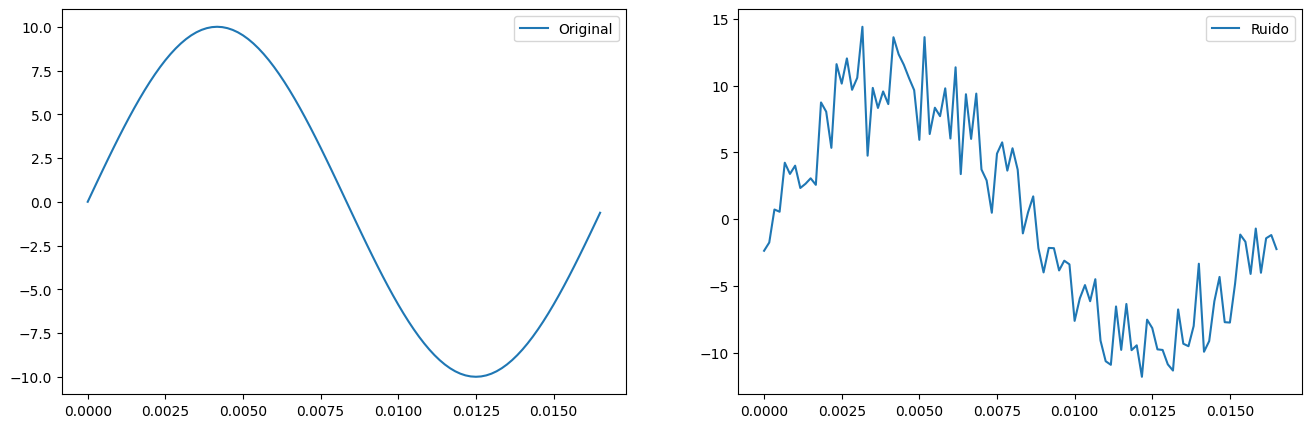

In [10]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(X, tt, label='Original')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X, t, label='Ruido')
plt.legend()
plt.show()

Grado polinomio óptimo: 3


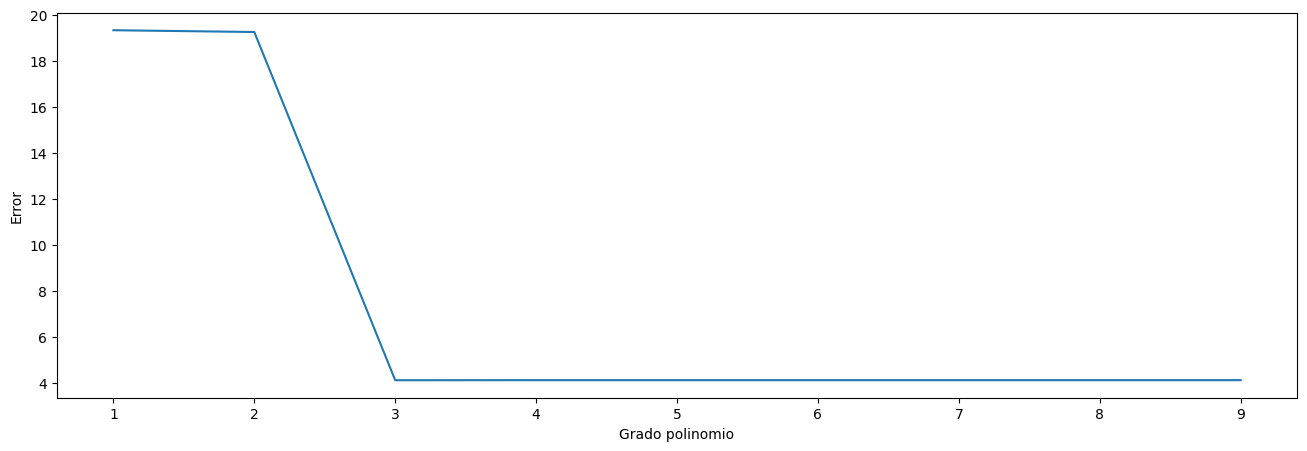

In [18]:
print(f"Grado polinomio óptimo: {np.argmin(error)+1}")
plt.figure(figsize=(16,5))
plt.plot(Q, error)
plt.xticks(Q)
plt.xlabel('Grado polinomio')
plt.ylabel('Error')
plt.show()

#Cross-Validation

In [32]:
error_cross = np.zeros(len(Q))

# cross-validation with multiple splits
rs_cross = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2)

lambdaR = 1e-15

for idx, q in enumerate(Q):
    phiQ = PolynomialFeatures(degree=q)
    Phi = phiQ.fit_transform(X)

    errs = []  # store errors for each split
    for train_i, test_i in rs.split(X):
        reg_mc = Ridge(alpha=lambdaR)
        reg_mc.fit(Phi[train_i], t[train_i])
        t_mc = reg_mc.predict(Phi[test_i])

        errs.append(np.linalg.norm(tt[test_i] - t_mc))

    # mean error across splits
    error_cross[idx] = np.mean(errs)

print("Cross-validation errors per polynomial degree:", error)

Cross-validation errors per polynomial degree: [19.33594245 19.25851727  4.10461387  4.1070606   4.10706554  4.10706554
  4.10706554  4.10706554  4.10706554]


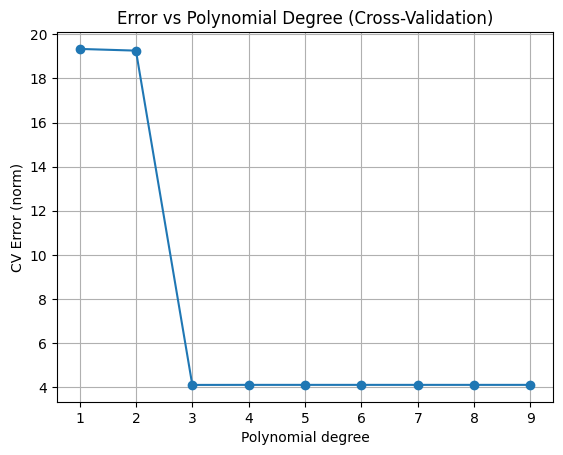

In [33]:
plt.plot(Q, error, marker='o')
plt.xlabel("Polynomial degree")
plt.ylabel("CV Error (norm)")
plt.title("Error vs Polynomial Degree (Cross-Validation)")
plt.grid(True)
plt.show()